# 问题
- 偏置单元要不要使用激活函数/反向传播时要不要求导

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path

DATA_DIR = Path('../data')
rng = np.random.default_rng()

In [2]:
def pad(a, v=1):
    if a.ndim == 1:
        a = np.pad(a, (1, 0), constant_values=v)
    else:
        a = np.pad(a, ((0, 0), (1, 0)), constant_values=v)
    return a

In [3]:
def load_data(
    path=DATA_DIR / 'ex4data1.mat',
    transpose=True,
    zero=True,
    one_hot=True,
    pad=False,
):
    data = sio.loadmat(path)
    X = data['X']
    y = data['y'].reshape(-1)
    if transpose:
        for i, v in enumerate(X):
           X[i] = v.reshape((20,  20), order='F').reshape(-1)
    if pad:
        X = np.pad(X, ((0, 0), (1, 0)), constant_values=1)
    if zero:
        y[y==10] = 0
    if one_hot:
        enc = OneHotEncoder()
        y = enc.fit_transform(y.reshape(-1, 1)).toarray()
    return X, y

In [4]:
def show_data(X):
    # figsize=(100, 100)
    pick_idxes = rng.choice(np.arange(X.shape[0]), 100)
    pick_X = X[pick_idxes]
    data = np.ones((209, 209)) # pad = 1
    row = 0
    for i in range(10):
        _row = row + 20
        col = 0
        for j in range(10):
            _col = col + 20
            data[row:_row, col:_col] = pick_X[i*10+j].reshape((20, 20))
            col = _col + 1
        row = _row + 1
    fig, ax = plt.subplots(figsize=(11, 11))
    ax.matshow(data, cmap=cm.binary)
    plt.xticks(np.array([]))  # just get rid of ticks
    plt.yticks(np.array([]))
    return pick_idxes, fig

[[9 7 1 4 7 1 4 4 6 3]
 [7 0 7 0 5 8 7 3 7 8]
 [8 8 9 2 8 0 5 5 3 2]
 [4 4 7 3 7 5 2 8 3 2]
 [2 4 1 6 0 9 8 4 2 1]
 [7 2 4 2 7 9 5 1 3 2]
 [0 7 0 9 1 0 4 4 2 9]
 [1 0 7 7 2 3 0 2 2 2]
 [9 1 7 1 4 6 3 0 3 5]
 [4 7 2 3 8 0 5 3 6 5]]


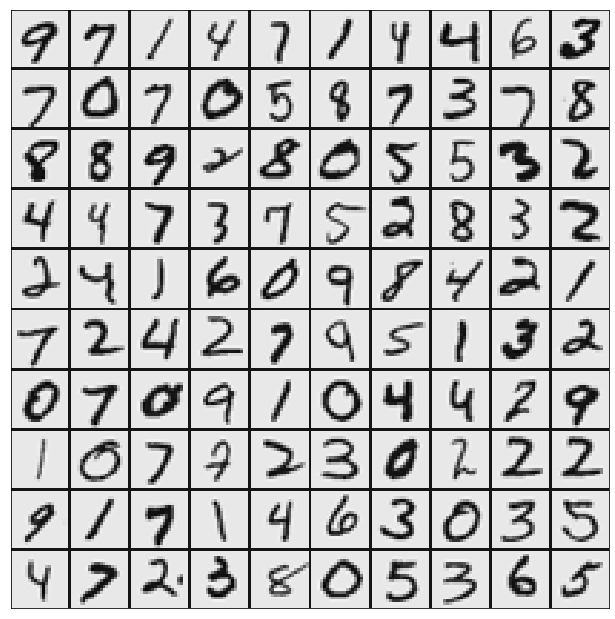

In [5]:
X, y = load_data(one_hot=False)
pick_idxes, fig = show_data(X)
fig.show()
print(y[pick_idxes].reshape((10, 10)))

In [6]:
def matritize_theta(theta):
    return theta[:25 * 401].reshape(25, 401), theta[25 * 401:].reshape(10, 26)

def vectorize_theta(theta1, theta2):
    return np.concatenate((np.ravel(theta1), np.ravel(theta2)))

In [7]:
weights = sio.loadmat(DATA_DIR / 'ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']
theta = vectorize_theta(theta1, theta2)  # 25*401+10*26=10285

theta1.shape, theta2.shape, theta.shape

((25, 401), (10, 26), (10285,))

In [8]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [9]:
def forward_propagate(X, theta1, theta2):
    a1 = np.pad(X, ((0, 0), (1, 0)), constant_values=1)
    z2 = a1 @ theta1.T # not pad
    a2 = np.pad(sigmoid(z2), ((0, 0), (1, 0)), constant_values=1)
    z3 = a2 @ theta2.T # not pad
    h = sigmoid(z3) # a3
    return a1, z2, a2, z3, h

In [10]:
def nn_cost_fn(theta, X, y):
    theta1, theta2 = matritize_theta(theta)
    *_, h = forward_propagate(X, theta1, theta2)
    print(h.shape, y.shape)
    return -(np.log(h) * y + np.log(1-h) * (1 - y)).sum() / X.shape[0]

In [11]:
X, y = load_data(zero=False, transpose=False)
nn_cost_fn(theta, X, y)

(5000, 10) (5000, 10)


0.2876291651613189

In [12]:
def nn_reg_cost_fn(theta, X, y, reg_param=1):
    m = X.shape[0]
    theta1, theta2 = matritize_theta(theta)
    *_, h = forward_propagate(X, theta1, theta2)
    reg_t1 = (reg_param / (2 * m)) * (theta1[:, 1:] ** 2).sum()
    reg_t2 = (reg_param / (2 * m)) * (theta2[:, 1:] ** 2).sum()
    return -(np.log(h) * y + np.log(1-h) * (1 - y)).sum() / m  + reg_t1 + reg_t2


In [13]:
X, y = load_data(zero=False, transpose=False)
nn_reg_cost_fn(theta, X, y)

0.38376985909092365

In [14]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

In [15]:
def init_theta(size, epsilon=0.12):
    return rng.uniform(-epsilon, epsilon, size)

In [16]:
def nn_gradient_fn(theta, X, y):
    m = X.shape[0]
    # theta1: (25,401) theta2: (10,26)
    theta1, theta2 = matritize_theta(theta)
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

    delta1 = np.zeros_like(theta1) # theta1: (25,401)
    delta2 = np.zeros_like(theta2) # theta2: (10,26)
    # TODO 向量化
    for i in range(m):
        a1i = a1[i].reshape(1, -1) # (1,401)
        z2i = z2[i].reshape(1, -1) # (1,25)
        a2i = a2[i].reshape(1, -1) # (1,26)
    
        hi = h[i].reshape(1, -1) # (1,10)
        yi = y[i].reshape(1, -1) # (1,10)

        d3i = hi - yi # (1,10)
        # FIXME 先pad后激活，与前馈不符
        z2i = np.pad(z2i, ((0, 0), (1, 0)), constant_values=1) # (1,26)
        d2i = (d3i @ theta2) * sigmoid_gradient(z2i) # (1,26)
        delta2 += d3i.T @ a2i # (10, 26)
        delta1 += d2i.T[1:] @ a1i # (25,1)x(1,401)
    return vectorize_theta(delta1, delta2) / m


In [17]:
X, y = load_data(zero=False, transpose=False)
d1, d2 = matritize_theta(nn_gradient_fn(theta, X, y))
d1.shape, d2.shape

((25, 401), (10, 26))

# 梯度校验

暂不实现。

重点：两个梯度的比较时向量和向量的比较，需要使用范数。

课程参考实现是：
```python
np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)
```

In [18]:
def _nn_reg_gradient_fn(theta, X, y, reg_params=1):
    m = X.shape[0]
    # theta1: (25,401) theta2: (10,26)
    theta1, theta2 = matritize_theta(theta)
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

    delta1 = np.zeros_like(theta1) # theta1: (25,401)
    delta2 = np.zeros_like(theta2) # theta2: (10,26)
    # 太慢了
    for i in range(m):
        a1i = a1[i].reshape(1, -1) # (1,401)
        z2i = z2[i].reshape(1, -1) # (1,25)
        a2i = a2[i].reshape(1, -1) # (1,26)
    
        hi = h[i].reshape(1, -1) # (1,10)
        yi = y[i].reshape(1, -1) # (1,10)

        d3i = hi - yi # (1,10)
        # FIXME 先pad后激活(求导)，与前馈不符
        z2i = np.pad(z2i, ((0, 0), (1, 0)), constant_values=1) # (1,26)
        d2i = (d3i @ theta2) * sigmoid_gradient(z2i) # (1,26)
        delta2 += d3i.T @ a2i # (10, 26)
        delta1 += d2i.T[1:] @ a1i # (25,1)x(1,401)
    delta1[:, 1:] += reg_params * theta1[:, 1:]
    delta2[:, 1:] += reg_params * theta2[:, 1:]
    return vectorize_theta(delta1, delta2) / m

In [19]:
'''
h: (5000,10)
  z3: (5000,10)
a2: (5000,26)
  z2: (5000, 25) 
a1: (5000,401)
d3: (5000,10)
d2: (5000,26)
delta2: (10,26)
delta1: (25,401)
'''
def nn_reg_gradient_fn(theta, X, y, reg_params=1):
    m = X.shape[0]
    # theta1: (25,401) theta2: (10,26)
    theta1, theta2 = matritize_theta(theta)
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    d3 = h - y # (5000,10)
    delta2 = d3.T @ a2 # (10,26)
    z2 = np.pad(z2, ((0, 0), (1, 0)), constant_values=1)
    d2 = (d3 @ theta2) * sigmoid_gradient(z2) # (5000,26)
    delta1 = d2.T[1:] @ a1
    delta1[:, 1:] += reg_params * theta1[:, 1:]
    delta2[:, 1:] += reg_params * theta2[:, 1:]
    return vectorize_theta(delta1, delta2) / m

In [20]:
X, y = load_data(zero=False, transpose=False)
d1, d2 = matritize_theta(nn_reg_gradient_fn(theta, X, y))
d1.shape, d2.shape
# d2

((25, 401), (10, 26))

In [21]:
X, y = load_data(zero=False, transpose=False)

res = opt.minimize(fun=nn_reg_cost_fn,
                   x0=init_theta(10285),
                   args=(X, y, 1),
                   method='TNC',
                   jac=nn_reg_gradient_fn,
                   options={'maxiter': 400}
                )

In [22]:
res

     fun: 0.31217966229727123
     jac: array([-3.15324362e-05, -8.39887441e-08, -2.95861826e-08, ...,
       -6.09679887e-05, -9.31407482e-05, -6.99280861e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 27
  status: 3
 success: False
       x: array([ 1.04271898e+00, -4.19943721e-04, -1.47930913e-04, ...,
       -5.18505095e+00, -3.82009679e-01, -2.58764299e+00])

In [23]:
final_t1, final_t2 = matritize_theta(res.x)
X, y = load_data(zero=False, transpose=False, one_hot=False)
*_, h = forward_propagate(X, final_t1, final_t2)
y_pred = np.argmax(h, axis=1) + 1
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       500
           2       0.99      0.99      0.99       500
           3       1.00      0.99      0.99       500
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      0.99      0.99       500
           8       0.99      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       1.00      1.00      1.00       500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



# 可视化隐藏层


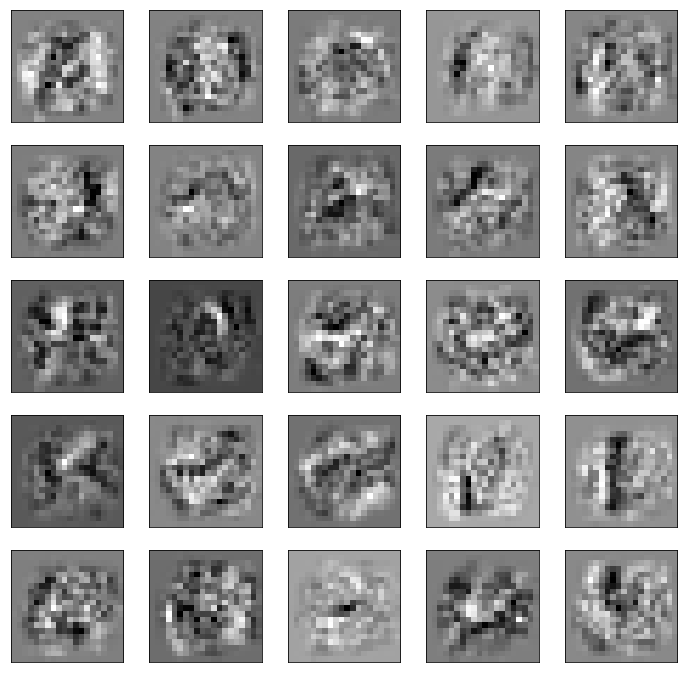

In [24]:
hidden_layer = final_t1[:, 1:]

fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(12, 12))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(hidden_layer[5 * r + c].reshape((20, 20))),cmap=cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 